# Imports

In [1]:
import pandas as pd
import warnings
from lifelines import CoxPHFitter, CoxTimeVaryingFitter
import re
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/base_modelis_pass_det.csv',sep = ';')

# Data treatment

In [3]:
df['date_entree_defaut'] = pd.to_datetime(df['date_entree_defaut'], format='%d/%m/%y')
df['date_sortie_defaut'] = pd.to_datetime(df['date_sortie_defaut'], format='%d/%m/%y', errors='coerce')
df['arrete'] = pd.to_datetime(df['arrete'], format='%d/%m/%y')
df['DT_MEP_OPE'] = pd.to_datetime(df['DT_MEP_OPE'], format='%d%b%Y:%H:%M:%S.%f')
df['dt_arr_last_enc_ope'] = pd.to_datetime(df['dt_arr_last_enc_ope'], errors='coerce')
df['dt_arr_1st_enc_ope'] = pd.to_datetime(df['dt_arr_1st_enc_ope'], errors='coerce')
df['dtHJD_prov'] = pd.to_datetime(df['dtHJD_prov'], errors='coerce')
df['dtHJD_def'] = pd.to_datetime(df['dtHJD_def'], errors='coerce')

In [4]:
for column in df.columns :
    if df[column].isna().sum()/df.shape[0] > 0.2 : 
        df.drop(columns = [column], inplace = True)

In [5]:
df.drop(columns = ["CD_POST_BIEN_PFI"], inplace = True)

In [6]:
cols_numeriques = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cols_categorielles = df.select_dtypes(include=['object']).columns.to_list()
cols_categorielles.remove("cd_op")

for col in cols_numeriques:
    df[col].fillna(df[col].mean(), inplace=True)

for col in cols_categorielles:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Train validation split

In [7]:
df_validation = df[df['arrete']>"2020-12-30"]
df_train = df[df['arrete']<"2020-12-30"]
df_train = df_train.reset_index()

# Feature selection

In [8]:
#liste_var = ['cd_op','fl_pass_DET','arrete','date_entree_defaut','fam_ENQ','solution','FL_REL_NON_ANNULE','niv_gravite_mtf_dne','CD_SITFAM_EMP1','regroup_natur_op','PTG','fl_fam_vam','fam_PCD','AMI','CD_ETAT_CIVIL','CD_NAT_EMP1','niv_gravite_mtf_dne','FL_REL_NON_ANNULE','sol_echec','fl_def_ss_pass_CTX','nb_empr_ope','CD_MTF_DFC','FL_ETR']
liste_var = df.columns.to_list()

In [9]:
df_train_var = df[liste_var].copy()
df_test_var = df_validation[liste_var].copy()

# Selection des individus réellement censurés et des fl_pass_DET=1

In [10]:
df_train_var.index = df_train_var['cd_op'] # etape temporaire pour récupérer les cd_op plus facielement
df_test_var.index = df_test_var['cd_op']

In [11]:
liste_target_1 = df_train_var[df_train_var['fl_pass_DET']==1].index.to_list() # on récupère les données non censurées
liste_target_1_test = df_test_var[df_test_var['fl_pass_DET']==1].index.to_list()

In [12]:
liste_target_censure = df_train_var[df_train_var['arrete']=='2022-12-31'].index.to_list() # on recupère les id censurés
liste_target_censure_test = df_test_var[df_test_var['arrete']=='2022-12-31'].index.to_list()

In [13]:
liste_target_censure.extend(liste_target_1) # on combine les 2 listes
liste_target_censure_test.extend(liste_target_1_test)

In [14]:
liste_cd_op = set(liste_target_censure) # on supprime les doublons
liste_cd_op = list(liste_cd_op)

liste_cd_op_test = set(liste_target_censure_test) # on supprime les doublons
liste_cd_op_test = list(liste_cd_op_test)

In [15]:
len(liste_cd_op) # On a donc 11301 individus à traiter dans notre base de données

11301

In [16]:
data = df_train_var[df_train_var['cd_op'].isin(liste_cd_op)]
data_test = df_test_var[df_test_var['cd_op'].isin(liste_cd_op_test)]

data.shape

(175878, 69)

# Encoding

In [17]:
def encode_columns(df):
    encoders = {}
    for column in df.select_dtypes(include='object'):
        unique_values = df[column].nunique()
        if unique_values <= 1:
            # Appliquer OneHotEncoder
            encoder = OneHotEncoder(sparse=False)
            encoded = encoder.fit_transform(df[[column]])
            encoders[column] = encoder

            # Remplacer la colonne originale par de nouvelles colonnes pour chaque catégorie
            for i, category in enumerate(encoder.categories_[0]):
                df[str(column) + '_' + str(category)] = encoded[:, i]
            df.drop(column, axis=1, inplace=True)
        else:
            # Appliquer LabelEncoder
            encoder = TargetEncoder()
            df[column] = encoder.fit_transform(df[column].values.reshape(-1, 1), df['fl_pass_DET'])
            encoders[column] = encoder
    return df, encoders

encoded_df, encoders = encode_columns(data.drop(columns = ['cd_op','arrete','date_entree_defaut']))
encoded_test, encoder_test = encode_columns(data_test.drop(columns = ['cd_op','arrete','date_entree_defaut']))

In [18]:
encoded_df['cd_op']  = data.index
encoded_df['fl_pass_DET'] = data['fl_pass_DET'].copy()
encoded_df['date_entree_defaut'] = data['date_entree_defaut'].copy()
encoded_df['arrete'] = data['arrete'].copy()

In [19]:
encoded_test['cd_op']  = data_test['cd_op'].copy()
encoded_test['fl_pass_DET'] = data_test['fl_pass_DET'].copy()
encoded_test['date_entree_defaut'] = data_test['date_entree_defaut'].copy()
encoded_test['arrete'] = data_test['arrete'].copy()

# Data prep for cox model

In [20]:
data_haz = encoded_df.copy()
data_test =encoded_test.copy()

In [21]:
data_haz['start'] = 0
data_haz['stop'] = data_haz['arrete'] - data_haz['date_entree_defaut']
data_haz['stop'] = data_haz['stop'].dt.days

data_test['start'] = 0
data_test['stop'] = data_test['arrete'] - data_test['date_entree_defaut']
data_test['stop'] = data_test['stop'].dt.days

In [22]:
data_haz['id'] = data_haz['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))


data_test['id'] = data_test['cd_op'].apply(lambda x: re.sub(r'\D', '', str(x)))

In [23]:
data_haz.id = data_haz.id.astype('int')

In [24]:
data_haz.loc[(data_haz['start'] == data_haz['stop']) & (data_haz['start'] == 0) & data_haz[
    'fl_pass_DET'], 'stop'] = 0.5  # car le modele n'accepte pas les individus qui sortent de la survie au moment ou ils y entrent donc on remplace les 0 par 0.5.

data_test.loc[(data_test['start'] == data_test['stop']) & (data_test['start'] == 0) & data_test[
    'fl_pass_DET'], 'stop'] = 0.5 

In [25]:
data_haz = data_haz.select_dtypes(exclude=["datetime64"])

data_test = data_test.select_dtypes(exclude=["datetime64"])

In [26]:
data_haz.drop(columns = ["cd_op"], inplace = True)


data_test.drop(columns = ["cd_op"], inplace = True)

In [27]:
data_haz.drop(columns = ['FL_REL_NON_ANNULE', 'niv_gravite_mtf_dne', 'niv_gravite_mtf_dne'],inplace = True)

In [28]:
data_haz.shape

(175878, 64)

In [72]:
11301-3838

7463

# Modelisation

In [30]:
data_cox = data_haz.drop_duplicates(subset = "id",keep = 'last') # on retire les doublons
test_cox = data_test.drop_duplicates(subset = "id",keep = 'last') # on retire les doublons
test_cox.drop(columns = ['start','fl_pass_DET', 'id'],inplace = True )

In [31]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)  # Choisir le paramètre de pénalité
cph.fit(data_cox.drop(columns = ['id','start']), duration_col='stop', event_col='fl_pass_DET')


<lifelines.CoxPHFitter: fitted with 11301 total observations, 3838 right-censored observations>

In [32]:
predictions = cph.predict_survival_function(test_cox)


In [33]:
predictions = predictions.transpose()

In [34]:
predictions.shape

(6295, 1454)

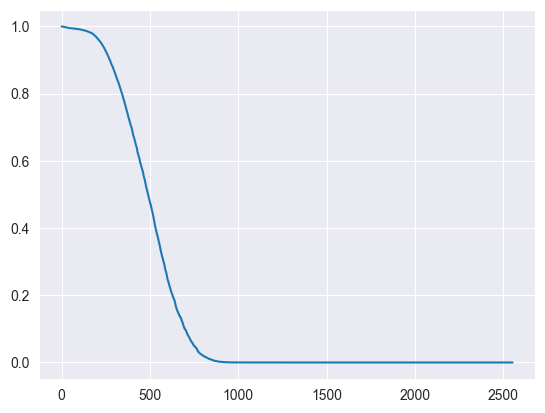

In [75]:
survival_function_observation_0 = predictions.iloc[746]

# Tracer la fonction de survie pour l'observation 0
survival_function_observation_0.plot()
plt.show()

In [36]:
cph.check_assumptions(data_cox.drop(columns = ['id','start']))

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 11301 total observations, 3838 right-censored observations>
         test_name = proportional_hazard_test

---
                             test_statistic      p  -log2(p)
AGE_EMP1               km              1.64   0.20      2.32
                       rank            1.71   0.19      2.39
AMI                    km              8.08 <0.005      7.80
                       rank            7.66   0.01      7.47
ANC_BANC_MAX_PFI       km              0.10   0.75      0.41
                       rank            0.09   0.76      0.40
ANC_PRO_MAX_PFI        km              0.37   0.54      0.88
                       rank            0.47   0.49      1.02
CD_CSP_EMP1            km              0.17   0.68      0.56
                       rank            0.17   0.68      0.56
CD_DEST_PFI            km              4.25   0.04      4.67
                       rank            4.22   0.04      4.64
CD_DNE_CHR_LGD_SAIN    km              6.75   0.01      6.73
                       rank            7.61   0.01      7.43
CD_ETAT_CIVIL          km              0.01   0.94      0.09
                       rank            0.01   0.91      0.14
CD_MTF_DFC             km              0.13   0.72      0.47
                       rank            0.10   0.75      0.41
CD_MTF_ENE_CTX         km              0.34   0.56      0.83
                       rank            0.27   0.60      0.73
CD_NATUR_OP_PFI        km              0.01   0.92      0.12
                       rank            0.02   0.89      0.17
CD_NAT_EMP1            km              1.82   0.18      2.49
                       rank            1.90   0.17      2.57
CD_SITFAM_EMP1         km              0.57   0.45      1.15
                       rank            0.70   0.40      1.31
EAD_1an_avant_def      km             13.95 <0.005     12.38
                       rank           14.87 <0.005     13.08
EXE                    km              1.04   0.31      1.70
                       rank            0.89   0.34      1.54
FL_ETR                 km              0.02   0.88      0.18
                       rank            0.03   0.87      0.21
MR_arr                 km              7.62   0.01      7.44
                       rank            8.07 <0.005      7.80
MT_CHA_HORS_OPE_PFI    km              0.00   0.96      0.06
                       rank            0.00   0.95      0.08
MT_CHG_MSL             km              0.07   0.79      0.34
                       rank            0.15   0.69      0.53
MT_EAD_DNE_CHR_d       km              2.47   0.12      3.11
                       rank            1.77   0.18      2.44
MT_EAD_RESID           km              3.16   0.08      3.73
                       rank            2.43   0.12      3.07
MT_FMG                 km              7.86   0.01      7.62
                       rank            7.95 <0.005      7.70
MT_PATRIM_MOB          km              0.17   0.68      0.55
                       rank            0.12   0.73      0.45
MT_PATRIM_NET          km              0.07   0.79      0.34
                       rank            0.06   0.80      0.32
MT_REST_VIVRE          km              0.03   0.87      0.19
                       rank            0.04   0.85      0.24
MT_REV_PFI             km              0.01   0.94      0.09
                       rank            0.00   0.95      0.07
NB_CHARGE_HORS_OPE_PFI km              0.73   0.39      1.34
                       rank            0.64   0.42      1.24
NB_DUR_PFI             km              1.69   0.19      2.36
                       rank            1.32   0.25      1.99
PTG                    km              0.11   0.74      0.44
                       rank            0.12   0.72      0.47
TX_APPOR               km              4.77   0.03      5.11
                       rank            4.72   0.03      5.07



1. Variable 'cum_dec' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'cum_dec' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'cum_dec' using pd.cut, and then specify it in
`strata=['cum_dec', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'cum_frs_externes' failed the non-proportional test: p-value is 0.0032.

   Advice 1: the functional form of the variable 'cum_frs_externes' might be incorrect. That is,
there may be non-linear terms missing. The proportional hazard test used is very sensitive to
incorrect functional forms. See documentation in link [D] below on how to specify 

[]

In [45]:
cph.AIC_partial_

111509.54473965106

In [51]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 11301 total observations, 3838 right-censored observations>
             duration col = 'stop'
                event col = 'fl_pass_DET'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 11301
number of events observed = 7463
   partial log-likelihood = -55694.77
         time fit was run = 2024-01-24 12:46:02 UTC

---
                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                      
nb_prt                   0.02       1.02       0.02            -0.03             0.06                 0.97                 1.07
CD_NAT_EMP1             11.16   70335.72       7.93            -4.38            26.71                 0.01             3.97e+11
ANC_BANC_MAX_PFI         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD_DEST_PFI              4.07      58.61       3.00            -1.82             9.96                 0.16             21127.76
CD_NATUR_OP_PFI          3.73      41.80       3.87            -3.86            11.33                 0.02             82991.09
MT_PATRIM_MOB            0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_CHA_HORS_OPE_PFI     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
NB_CHARGE_HORS_OPE_PFI  -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
MT_PATRIM_NET           -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
MT_REV_PFI              -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
NB_DUR_PFI              -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
TX_APPOR                 0.04       1.04       0.03            -0.02             0.11                 0.98                 1.12
FL_ETR                  -0.03       0.97       0.03            -0.09             0.03                 0.91                 1.03
CD_ETAT_CIVIL            0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
CD_CSP_EMP1              5.42     226.42       3.28            -1.01            11.85                 0.37             1.40e+05
CD_SITFAM_EMP1           5.32     204.34       4.01            -2.54            13.18                 0.08             5.30e+05
cum_dec                  0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
cum_rec                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
cum_frs_externes        -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
CD_DNE_CHR_LGD_SAIN      0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
MT_EAD_RESID            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MT_EAD_DNE_CHR_d        -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
fl_prise_de_gar          0.03       1.03       0.04            -0.05             0.12                 0.95                 1.12
fl_fam_vam               0.24       1.27       0.03             0.18             0.30                 1.19                 1.35
fam_ETH                 -0.61       0.54       0.04            -0.69            -0.53                 0.50                 0.59
fam_ENQ                 -0.15       0.86       0.02            -0.19            -0.10                 0.82   

<Axes: >

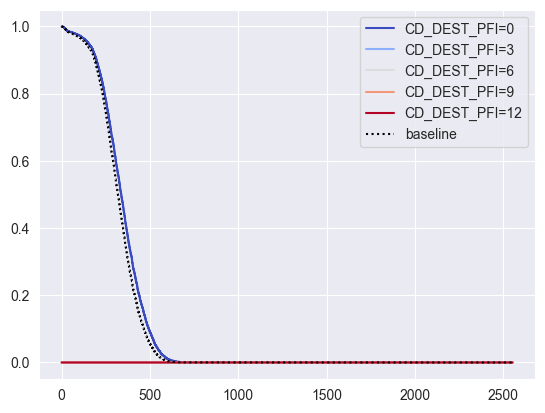

In [53]:
import numpy as np
cph.plot_partial_effects_on_outcome('CD_DEST_PFI', values=np.arange(0, 15, 3), cmap='coolwarm')